# Set up Environment

In [1]:
# Activate Virtual Environment and Install Requirements
#!python3 -m venv ../chmenv
#!source ../chmenv/bin/activate
#!python3 -m ipykernel install --user --name=chmenv --display-name "Python (chmenv)"
#remember to switch to notebook/virtual environment kernel
#!pip install -r requirements.txt # install requirements text in new environment
#!jupyter kernelspec uninstall chmenv

In [1]:
# Import Packages
import os
from pathlib import Path
import re

import numpy as np
import pandas as pd
import matplotlib

import shutil
import itertools

import nilearn
from nilearn.image import load_img
from nilearn.image import math_img
from nilearn import plotting, datasets
import glob

import nibabel as nib
import nibabel.processing

# EDA

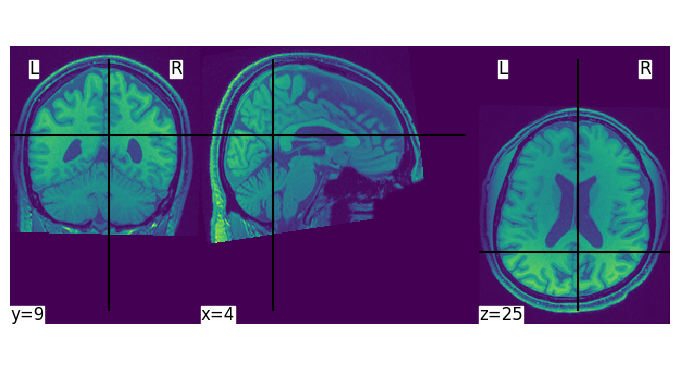

In [3]:
# Paths

# Preprocessed Image
image_path = 'Original_Data/ABIDE1/CALTECH/sub-0051456/anat/sub-0051456_T1w.nii.gz'
#image_path = 'Original_Data/ABIDE2/ABIDEII-BNI_1/sub-29006/ses-1/anat/sub-29006_ses-1_run-1_T1w.nii.gz'
#image_path = 'Original_Data/ACE/sub-HAR30003/anat/sub-HAR30003_T1w.nii.gz'

# Load Image
img = nilearn.image.load_img(image_path)

# Plot
plotting.plot_img(image_path)

In [4]:
print(img.get_fdata().shape)
print(img.header)

(176, 256, 256)
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 176 256 256   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [-1.    1.    1.    1.    1.59  0.    0.    0.  ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'FSL4.1'
aux_file        : b''
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.0
quatern_c       : 1.0
quatern_d       : 0.0
qoffset_x       : 88.855934
qoffset_y       : -55.81357
qoffset_z       : -

# Create TSV Files and Summary Tables

## ABIDEII

In [5]:
# Took out UCLA because not in Garcia paper (and UCLA in ABIDEI)

In [6]:
#### Participant TSV File ####

# Load metadata file
participants = pd.read_csv('Original_Data/Metadata/ABIDEII_Composite_Phenotypic.csv')

# Remove UCLA
participants = participants[participants['SITE_ID'] != 'ABIDEII-UCLA_1']

# Subset columns needed
participants = participants[["SUB_ID", "DX_GROUP", "SITE_ID"]]

# Change labels: 1 -> 1 (Autism), 2 -> 0 (non-Autism)
participants["DX_GROUP"] = participants["DX_GROUP"].replace({2: 0})

# Train/test split using vectorized operations
participants["dataset"] = "train"
participants.loc[
    participants["SITE_ID"].isin(["ABIDEII-EMC_1", "ABIDEII-UCD_1"]),
    "dataset",
] = "test"

#Split train into train and val (15% val)
train_indices = participants[participants["dataset"] == "train"].index
val_sample = np.random.choice(train_indices, size=int(0.15 * len(train_indices)), replace=False)
participants.loc[val_sample, "dataset"] = "val"

# Rename columns to match
participants.rename(columns={"SUB_ID": "participant_id", "DX_GROUP": "label"}, inplace=True)

# Remove site id column
participants_tsv = participants.drop('SITE_ID', axis=1)

# Export participants.tsv file
participants_tsv.to_csv('Original_Data/Metadata/ABIDEII_participants.tsv', sep='\t', index=False)

In [7]:
#### Participant Summary Table ####

# Add total row to count all labels per site
participants_with_total = pd.concat([
    participants,
    participants.assign(label='total')
])

# Group and pivot
summary = (
    participants_with_total
    .groupby(['SITE_ID', 'label', 'dataset'])
    .size()
    .reset_index(name='count')
    .pivot_table(index=['SITE_ID', 'label'], columns='dataset', values='count', fill_value=0)
    .astype(int)
    .reset_index()
)

# Rename labels
label_mapping = {'total': 'Total', 1: 'Autism', 0: 'No Autism'}
summary["label"] = summary["label"].map(label_mapping)

# Reorder rows so "Total" comes first per SITE_ID
summary["label_order"] = summary["label"].map({'Total': 0, 'Autism': 1, 'No Autism': 2})
summary.sort_values(by=["SITE_ID", "label_order"], inplace=True)
summary.drop(columns="label_order", inplace=True)

# Hide repeated SITE_IDs for clarity
summary["SITE_ID"] = summary["SITE_ID"].mask(summary["SITE_ID"].duplicated(), "")

# Reorder columns
summary = summary[["SITE_ID", "label", "train", "val", "test"]]

# Export to CSV
summary.to_csv("Original_Data/Metadata/ABIDEII_Participant_Summary.csv", index=False)


#### Total Participants ####
print(participants.shape[0])

1082


## ACE

In [8]:
#### Participant TSV File ####

# Load metadata file
participants = pd.read_csv('Original_Data/Metadata/ACE_Composite_Phenotypic.csv')

# Subset columns needed
participants = participants[["Site ID", "Cohort", "site"]]

# Keep only the numeric part of Site ID
participants["Site ID"] = participants["Site ID"].astype(str).str.extract(r'(\d+)')

# Change labels: ASD -> 1 (Autism), CON & US -> 0 (non-Autism)
participants["Cohort"] = participants["Cohort"].replace({'CON': 0, 'US': 0, 'ASD': 1})

# Train/test split using vectorized operations
participants["dataset"] = "test"

# Rename columns to match
participants.rename(columns={"Site ID": "participant_id", "Cohort": "label"}, inplace=True)

# Remove site id column
participants_tsv = participants.drop('site', axis=1)

# Export participants.tsv file
participants_tsv.to_csv('Original_Data/Metadata/ACE_participants.tsv', sep='\t', index=False)

/tmp/ipykernel_838795/1886445191.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  participants["Cohort"] = participants["Cohort"].replace({'CON': 0, 'US': 0, 'ASD': 1})


In [9]:
#### Participant Summary Table ####

# Create label mapping
label_mapping = {1: 'Autism', 0: 'No Autism'}

# Count by site and label
label_counts = (
    participants
    .replace({'label': label_mapping})
    .groupby(['site', 'label'])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

# Add total column per site
label_counts["Total"] = label_counts["Autism"] + label_counts["No Autism"]

# Reorder columns
summary = label_counts[["site", "Total", "Autism", "No Autism"]]

# Add total row
total_row = pd.DataFrame({
    "site": ["Total"],
    "Total": [summary["Total"].sum()],
    "Autism": [summary["Autism"].sum()],
    "No Autism": [summary["No Autism"].sum()]
})

# Append total row to summary
summary = pd.concat([summary, total_row], ignore_index=True)

# Export to CSV
summary.to_csv("Original_Data/Metadata/ACE_Participant_Summary.csv", index=False)

#### Total Participants ####
print(participants.shape[0])

523


## ABIDEI

In [10]:
#### Participant TSV File ####

# Load metadata file
participants = pd.read_csv('Original_Data/Metadata/ABIDEI_Composite_Phenotypic.csv')

# Subset columns needed
participants = participants[["SUB_ID", "DX_GROUP", "SITE_ID"]]

# Change labels: 1 -> 1 (Autism), 2 -> 0 (non-Autism)
participants["DX_GROUP"] = participants["DX_GROUP"].replace({2: 0})

# Train/test split using vectorized operations
participants["dataset"] = "train"
participants.loc[
    participants["SITE_ID"].isin(["LEUVEN_1"]),
    "dataset",
] = "test"

#Split train into train and val (15% val)
train_indices = participants[participants["dataset"] == "train"].index
val_sample = np.random.choice(train_indices, size=int(0.15 * len(train_indices)), replace=False)
participants.loc[val_sample, "dataset"] = "val"

# Rename columns to match
participants.rename(columns={"SUB_ID": "participant_id", "DX_GROUP": "label"}, inplace=True)

# Remove site id column
participants_tsv = participants.drop('SITE_ID', axis=1)

# Export participants.tsv file
participants_tsv.to_csv('Original_Data/Metadata/ABIDEI_participants.tsv', sep='\t', index=False)

In [11]:
#### Participant Summary Table ####

# Add total row to count all labels per site
participants_with_total = pd.concat([
    participants,
    participants.assign(label='total')
])

# Group and pivot
summary = (
    participants_with_total
    .groupby(['SITE_ID', 'label', 'dataset'])
    .size()
    .reset_index(name='count')
    .pivot_table(index=['SITE_ID', 'label'], columns='dataset', values='count', fill_value=0)
    .astype(int)
    .reset_index()
)

# Rename labels
label_mapping = {'total': 'Total', 1: 'Autism', 0: 'No Autism'}
summary["label"] = summary["label"].map(label_mapping)

# Reorder rows so "Total" comes first per SITE_ID
summary["label_order"] = summary["label"].map({'Total': 0, 'Autism': 1, 'No Autism': 2})
summary.sort_values(by=["SITE_ID", "label_order"], inplace=True)
summary.drop(columns="label_order", inplace=True)

# Hide repeated SITE_IDs for clarity
summary["SITE_ID"] = summary["SITE_ID"].mask(summary["SITE_ID"].duplicated(), "")

# Reorder columns
summary = summary[["SITE_ID", "label", "train", "val", "test"]]

# Export to CSV
summary.to_csv("Original_Data/Metadata/ABIDEI_Participant_Summary.csv", index=False)


#### Total Participants ####
print(participants.shape[0])

1112


# Move files to BIDS Structure Directories

## ABIDEII

In [ ]:
# Define the original root and new destination directory
root_dir = "Original_Data/ABIDE2"
new_root_dir = "Restructured_Data/ABIDE2"  # New directory to store the copied files
metadata_dir = "Original_Data/Metadata"

In [24]:
# Load original Metadata File
test = pd.read_csv(os.path.join(metadata_dir, "ABIDEII_Composite_Phenotypic.csv"))
test = test[test['SITE_ID'] != 'ABIDEII-UCLA_1'] #Remove UCLA
print(len(test)) #1082

1082


In [28]:
# Load original participants.tsv
test = pd.read_csv(os.path.join(metadata_dir, "ABIDEII_participants.tsv"), sep="\t", dtype=str)
print(len(test)) #1082 - good!

1082


In [3]:
# Find all *_T1w.nii.gz files in the original structure
t1w_files = glob.glob(os.path.join(root_dir, "ABIDEII-*/sub-*/ses-1/anat/*_T1w.nii.gz"), recursive=True)
print(len(t1w_files)) #1244 - multiple runs per session sometimes

1244


In [4]:
#### BIDS FOLDER STRUCTURE ####

# Process each file
for file_path in t1w_files:
    # Extract subject ID from the path
    parts = file_path.split(os.sep)
    sub_index = parts.index("ses-1") - 1  # Index of the subject folder
    subject_id = parts[sub_index]

    # Define new directory and filename
    new_subject_dir = os.path.join(new_root_dir, subject_id, "anat")
    new_filename = f"{subject_id}_T1w.nii.gz"
    new_file_path = os.path.join(new_subject_dir, new_filename)

    # Create directories if they don't exist
    os.makedirs(new_subject_dir, exist_ok=True)

    # Copy the file instead of moving
    shutil.copy2(file_path, new_file_path) #re-writing over previous runs if multiple run - so last run for each subject kept (theoretically)

print("Reorganization complete! Files copied to:", new_root_dir)
lst = os.listdir(new_root_dir) # your directory path
number_files = len(lst)
print(number_files) #1012 - only taking the first run so less overall images (plus 1 for metadata file)

Reorganization complete! Files copied to: Restructured_Data/ABIDE2
1013


In [5]:
# Clean up tsv file to only include subjects with existing images

# Load original participants.tsv
df_participants = pd.read_csv(os.path.join(metadata_dir, "ABIDEII_participants.tsv"), sep="\t", dtype=str)

# Prepare a list to hold valid rows
valid_rows = []

# Loop through the dataframe and check if the corresponding file exists
for i, row in df_participants.iterrows():
    subid = row['participant_id']

    file_path = os.path.join(new_root_dir, f"sub-{subid}", "anat", f"sub-{subid}_T1w.nii.gz")

    if os.path.isfile(file_path):
        valid_rows.append(row)

# Create cleaned DataFrame
df_cleaned = pd.DataFrame(valid_rows)

# Save to a new TSV file
df_cleaned.to_csv(os.path.join(new_root_dir, "ABIDEII_participants_processed.tsv"), sep="\t", index=False)

print(df_cleaned.shape[0]) #1011 - 1 image didn't exist

1011


## ACE

In [2]:
# Define the original root and new destination directory
root_dir = "Original_Data/ACE"
new_root_dir = "Restructured_Data/ACE"  # New directory to store the copied files
metadata_dir = "Original_Data/Metadata"

In [3]:
# Load original Metadata File
test = pd.read_csv(os.path.join(metadata_dir, "ACE_Composite_Phenotypic.csv"))
print(len(test)) #523

523


In [12]:
# Load original participants.tsv
test = pd.read_csv(os.path.join(metadata_dir, "ACE_participants.tsv"), sep="\t", dtype=str)
print(len(test)) #523 - good!

523


In [13]:
# Find all *_T1w.nii.gz files in the original structure
t1w_files = glob.glob(os.path.join(root_dir, "sub-*/anat/*_T1w.nii.gz"), recursive=True)
print(len(t1w_files)) #461 - less images than in metadata file

461


In [19]:
#### BIDS FOLDER STRUCTURE ####

# Process each file
for file_path in t1w_files:
    # Extract subject ID from the path
    parts = file_path.split(os.sep)
    sub_index = parts.index("anat") - 1  # Index of the subject folder
    subject_id = parts[sub_index]
    
    # Remove the Site Characters from the subject number
    subject_id = re.sub(r"[a-zA-Z]", "", subject_id)

    # Define new directory and filename
    new_subject_dir = os.path.join(new_root_dir, f"sub{subject_id}", "anat")
    new_filename = f"sub{subject_id}_T1w.nii.gz"
    new_file_path = os.path.join(new_subject_dir, new_filename)

    # Create directories if they don't exist
    os.makedirs(new_subject_dir, exist_ok=True)

    # Copy the file instead of moving
    shutil.copy2(file_path, new_file_path) #re-writing over previous runs if multiple run - so last run for each subject kept (theoretically)

print("Reorganization complete! Files copied to:", new_root_dir)
lst = os.listdir(new_root_dir) # your directory path
number_files = len(lst)
print(number_files) #422 - only taking the first run so less overall images

Reorganization complete! Files copied to: Restructured_Data/ACE
422


In [21]:
# Clean up tsv file to only include subjects with existing images

# Load original participants.tsv
df_participants = pd.read_csv(os.path.join(metadata_dir, "ACE_participants.tsv"), sep="\t", dtype=str)

# Prepare a list to hold valid rows
valid_rows = []

# Loop through the dataframe and check if the corresponding file exists
for i, row in df_participants.iterrows():
    subid = row['participant_id']

    file_path = os.path.join(new_root_dir, f"sub-{subid}", "anat", f"sub-{subid}_T1w.nii.gz")

    if os.path.isfile(file_path):
        valid_rows.append(row)

# Create cleaned DataFrame
df_cleaned = pd.DataFrame(valid_rows)

# Save to a new TSV file
df_cleaned.to_csv(os.path.join(new_root_dir, "ACE_participants_processed.tsv"), sep="\t", index=False)

print(df_cleaned.shape[0]) #407 Some of the subjects not in the original metadata file

407


## ABIDEI

In [2]:
# Define the original root and new destination directory
root_dir = "Original_Data/ABIDE1"
new_root_dir = "Restructured_Data/ABIDE1"  # New directory to store the copied files
metadata_dir = "Original_Data/Metadata"

In [3]:
# Load original Metadata File
test = pd.read_csv(os.path.join(metadata_dir, "ABIDEI_Composite_Phenotypic.csv"))
print(len(test)) #1112

1112


In [4]:
# Load original participants.tsv
test = pd.read_csv(os.path.join(metadata_dir, "ABIDEI_participants.tsv"), sep="\t", dtype=str)
print(len(test)) #1112 - good!

1112


In [5]:
# Define the original root and new destination directory
root_dir = "Original_Data/ABIDE1"
new_root_dir = "Restructured_Data/ABIDE1"  # New directory to store the copied files
metadata_dir = "Original_Data/Metadata"

# Find all *_T1w.nii.gz files in the original structure
t1w_files = glob.glob(os.path.join(root_dir, "*/sub-*/anat/*_T1w.nii.gz"), recursive=True)
print(len(t1w_files)) #1102 - less images than in metadata file

1102


In [6]:
#### BIDS FOLDER STRUCTURE ####

# Process each file
for file_path in t1w_files:
    # Extract subject ID from the path
    parts = file_path.split(os.sep)
    sub_index = parts.index("anat") - 1  # Index of the subject folder
    subject_id = parts[sub_index]

    # Define new directory and filename
    new_subject_dir = os.path.join(new_root_dir, subject_id, "anat")
    new_filename = f"{subject_id}_T1w.nii.gz"
    new_file_path = os.path.join(new_subject_dir, new_filename)

    # Create directories if they don't exist
    os.makedirs(new_subject_dir, exist_ok=True)

    # Copy the file instead of moving
    shutil.copy2(file_path, new_file_path) #re-writing over previous runs if multiple run - so last run for each subject kept (theoretically)

print("Reorganization complete! Files copied to:", new_root_dir)
lst = os.listdir(new_root_dir) # your directory path
number_files = len(lst)
print(number_files) # Same number copied over!

Reorganization complete! Files copied to: Restructured_Data/ABIDE1
1102


In [8]:
# Clean up tsv file to only include subjects with existing images

# Load original participants.tsv
df_participants = pd.read_csv(os.path.join(metadata_dir, "ABIDEI_participants.tsv"), sep="\t", dtype=str)
# Add 2 leading zeros
df_participants['participant_id'] = df_participants['participant_id'].astype(str).str.zfill(7)

# Prepare a list to hold valid rows
valid_rows = []

# Loop through the dataframe and check if the corresponding file exists
for i, row in df_participants.iterrows():
    subid = row['participant_id']

    file_path = os.path.join(new_root_dir, f"sub-{subid}", "anat", f"sub-{subid}_T1w.nii.gz")

    if os.path.isfile(file_path):
        valid_rows.append(row)

# Create cleaned DataFrame
df_cleaned = pd.DataFrame(valid_rows)

# Save to a new TSV file
df_cleaned.to_csv(os.path.join(new_root_dir, "ABIDEI_participants_processed.tsv"), sep="\t", index=False)

print(df_cleaned.shape[0]) # Same number!

1102


# Remove Non-Brain Tissue

https://fsl.fmrib.ox.ac.uk/fsl/docs/#/structural/bet
https://git.fmrib.ox.ac.uk/fsl/fslpy

!pip install fslpy

In [51]:
import fsl

In [54]:
from fsl.wrappers import bet

## ABIDEII

In [58]:
#import subprocess

# Specify the input directory containing the NIfTI files
input_dir = "Restructured_Data/ABIDE2"

# Specify the output directory for the skull-stripped images
output_dir = "JustBrain_Data/ABIDE2"

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Find all *_T1w.nii.gz files in the original structure
t1w_files = glob.glob(os.path.join(input_dir, "sub-*/anat/*_T1w.nii.gz"), recursive=True)

# Loop through all files in the input directory
for filename in t1w_files:
    filename = re.match(r"^(?:[^\/]*\/){2}(.*)", filename).group(1)
    
    # Construct the full paths for the input and output files
    input_path = os.path.join(input_dir, filename)
    output_path = os.path.join(output_dir, filename)

    # Run FSL BET
    #command = ['bet', input_path, output_path]
    #subprocess.run(command)
    
    # Create a BET object
    #bet = fsl.BET(input_image, output_image)
    
    # Run the brain extraction
    #bet.run()

    bet(input_path, output_path)

print('Finished processing all files.')

FSLNotPresent: $FSLDIR is not set - FSL cannot be found!

## ACE

## ABIDEI